<h1 align="center">OpenMP part 2</h1> 

In [2]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import timeit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

/tmp/ipykernel_3832/3868817124.py:81: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_3832/3868817124.py:87: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


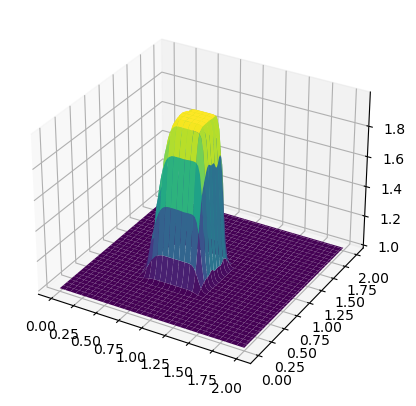

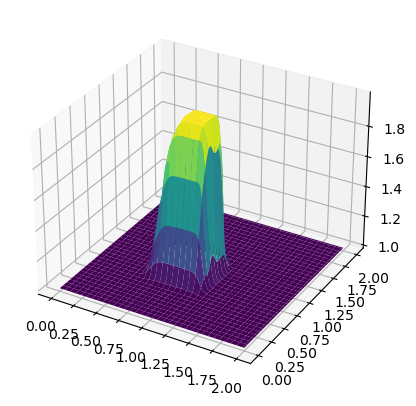

In [2]:
@types('float[:,:]', 'float[:,:]','float[:,:]', 'float[:,:]', 'int', 'float','float', 'float','float')
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy, c):
     
    #$ omp parallel
    
    #$ omp sections nowait
    #$ omp section
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    #$ omp end section
    
    #$ omp section 
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    #$ omp end section
    
    #$ omp section
    row, col = u.shape
    #$ omp end section
    #$ omp end sections
    
    
    #$ omp for 
    for n in range(nt):
        un[: , :]=u[: , :]
        vn[: , :]=v[: , :]
        for i in range(1,row):
            for j in range(1,col):
                u[i , j]= un[ i , j] - un[ i , j] * dt / dx * (un[i , j] - un[i-1 , j]) - vn[ i , j] * dt / dy * (un[i , j] - un[i , j-1]) 
                v[i , j]= vn[ i , j] - un[ i , j] * dt / dx * (vn[i , j] - vn[i-1 , j]) - vn[ i , j] * dt / dy * (vn[i , j] - vn[i , j-1])
      
   
    #$ omp sections nowait
    #$ omp section    
    u[0, :] = 1
    u[col-1, :] = 1
    u[:, 0] = 1
    u[:, row-1] = 1  
    #$ omp end section 
    #$ omp section 
    v[0, :] = 1
    v[col-1, :] = 1
    v[:, 0] = 1
    v[:, row-1] = 1  
    #$ omp end section 
    #$ omp end sections
    
    #$ omp end parallel
    return 0

if __name__=="__main__":
    from pyccel.stdlib.internal.openmp import omp_set_num_threads
    omp_set_num_threads(4)

    from pyccel.epyccel import epyccel
    p_nonlinearconv = epyccel(solve_2d_nonlinearconv_pure, language='c', accelerators=['openmp'])
    
    ###variable declarations
    nx = 101
    ny = 101
    nt = 80
    c = 1.
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx

    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    u = np.ones((ny, nx)) ##create a 1xn vector of 1's
    v = np.ones((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx))  
    
    td=timeit.default_timer()
    
    p_nonlinearconv(u, un, v, vn, nt, dt, dx, dy, c)
    
    tf=timeit.default_timer()-td

    fig = pyplot.figure(figsize=(7, 5), dpi=100)
    ax = fig.gca(projection='3d')                      
    X, Y = np.meshgrid(x, y)                            
    surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


    fig = pyplot.figure(figsize=(7, 5), dpi=100)
    ax = fig.gca(projection='3d')
    surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

In [55]:
tf

0.001332675001322059

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [3]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
 
    return b

def pressure_poisson_pure(p, dx, dy, b):
    row, col=p.shape
    
    pn = np.empty_like(p)
    #$ omp for parallel 
    for q in range(nt):
        pn = p.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
    
                    p[i, j] = (((pn[i+1, j] + pn[i-1, j]) * dy**2 + 
                                      (pn[i, j+1] + pn[i, j-1]) * dx**2) /
                                      (2 * (dx**2 + dy**2)) -
                                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                      b[i,j])
    

    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2
    #$ omp end parallel   
                  
    return p



In [3]:
@types('int','float[:,:]', 'float[:,:]','float','int','int','float','float','float[:,:]','int','float')
def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    import numpy as np
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    pn = np.empty_like(p)
    row, col=p.shape
     
    ##$ omp parallel
    ##$ omp for
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        
        b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

        
    ##$ omp for
    for q in range(nt):
        pn[: , :] = p[: , :]
        for i in range(1,row-1):
            for j in range(1,col-1):

                    p[i, j] = (((pn[i+1, j] + pn[i-1, j]) * dy**2 + 
                                        (pn[i, j+1] + pn[i, j-1]) * dx**2) /
                                        (2 * (dx**2 + dy**2)) -
                                        dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                        b[i,j])


    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2
         
        
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    ##$ omp sections nowait
    ##$ omp section
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1  
    ##$ omp end section
    #$# omp section
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
    ##$ omp end section
    ##$ omp end sections
        
    
        
    ##$ omp end parallel
        
    return 0

#if __name__=="__main__":
#    from pyccel.stdlib.internal.openmp import omp_set_num_threads
#    omp_set_num_threads(4)

from pyccel.epyccel import epyccel
py_cavity_flow= epyccel(cavity_flow_pure, language='c')

TypeError: exceptions must derive from BaseException

In [6]:
py_cavity_flow= epyccel(cavity_flow_pure, language='c', accelerators=['openmp'])


ERROR at Fortran compilation stage


RuntimeError: Failed to build module
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:139:1: warning: data definition has no type or storage class
  139 | free_array(un);
      | ^~~~~~~~~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:139:1: warning: type defaults to ‘int’ in declaration of ‘free_array’ [-Wimplicit-int]
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:139:1: warning: parameter names (without types) in function declaration
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:140:1: warning: data definition has no type or storage class
  140 | free_array(vn);
      | ^~~~~~~~~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:140:1: warning: type defaults to ‘int’ in declaration of ‘free_array’ [-Wimplicit-int]
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:140:1: warning: parameter names (without types) in function declaration
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:141:1: warning: data definition has no type or storage class
  141 | free_array(b);
      | ^~~~~~~~~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:141:1: warning: type defaults to ‘int’ in declaration of ‘free_array’ [-Wimplicit-int]
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:141:1: warning: parameter names (without types) in function declaration
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:142:1: warning: data definition has no type or storage class
  142 | free_array(pn);
      | ^~~~~~~~~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:142:1: warning: type defaults to ‘int’ in declaration of ‘free_array’ [-Wimplicit-int]
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:142:1: warning: parameter names (without types) in function declaration
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:143:1: error: expected identifier or ‘(’ before ‘return’
  143 | return 0;
      | ^~~~~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:144:1: error: expected identifier or ‘(’ before ‘}’ token
  144 | }
      | ^
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c: In function ‘cavity_flow_pure’:
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:57:17: error: work-sharing region may not be closely nested inside of work-sharing, ‘critical’, ‘ordered’, ‘master’, explicit ‘task’ or ‘taskloop’ region
   57 |         #pragma omp for
      |                 ^~~
/home/aurel/Documents/Al-Khwarizmi-HPC-Programming/day03/assignments/__epyccel__/__pyccel__/mod_evvspr7nuebi_evvspr7nuebi.c:105:17: error: work-sharing region may not be closely nested inside of work-sharing, ‘critical’, ‘ordered’, ‘master’, explicit ‘task’ or ‘taskloop’ region
  105 |         #pragma omp sections nowait
      |                 ^~~


In [28]:
@types('float[:,:]','float','float','float[:,:]','float[:,:]','float','float')
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    
    #$ omp parallel 
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    #$omp end parallel
    return 0


@types('float[:,:]','float','float','float[:,:]', 'int')
def pressure_poisson_numba(p, dx, dy, b, nt):
    import numpy as np
    
    row, col=p.shape
    pn = np.empty_like(p)
    
    #$ omp parallel
    #$ omp for
    for q in range(nt):
        pn[:,:] = p[:,:]
        for i in range(1,row-1):
            for j in range(1,col-1):
    
                    p[i, j] = (((pn[i+1, j] + pn[i-1, j]) * dy**2 + 
                                      (pn[i, j+1] + pn[i, j-1]) * dx**2) /
                                      (2 * (dx**2 + dy**2)) -
                                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                      b[i,j])

    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2
    
    #$ omp end parallel
    return 0
        
@types('int','float[:,:]', 'float[:,:]','float','int','int','float','float','float[:,:]','int','float')
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
     
    #$omp parallel
    #$ omp for
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        build_up_b_numba_py(b, rho, dt, u, v, dx, dy)
        pressure_poisson_numba_py(p, dx, dy, b)
        
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    #$ omp sections nowait
    ##$ omp section
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1  
    ##$ omp end section
    #$# omp section
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
    ##$ omp end section
    ##$ omp end sections
        
    
        
    ##$ omp end parallel
    
       
    return 0

In [9]:
build_up_b_numba_py= epyccel(build_up_b_numba, language='c', accelerators=['openmp'])

In [17]:
pressure_poisson_numba_py= epyccel(pressure_poisson_numba, language='c', accelerators=['openmp'])

In [27]:
cavity_flow_numba_py= epyccel(cavity_flow_numba, language='c', accelerators=['openmp'])

TypeError: exceptions must derive from BaseException